# Introduction to hax, part II

Last updated April 2018.

This notebook revisits the topics of Part I, going into a bit more detail. You'll learn how to
  * Peg your analysis to a specific pax version with `hax.init`,
  * Get metadata for runs with `hax.runs.get_run_info`
  * Load several datasets with `hax.minitrees`
  * Use cuts from `lax`

## Startup

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from pax import units
import hax

hax.init(pax_version_policy='6.8.0',
         minitree_paths=['.', '/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0'])

Notice we set two options to hax.init:

  * `pax_version_policy` controls what versions of the processed data the analysis is allowed to use. By default, hax uses any available version (preferring the latest one) for each dataset, even if that results in mixing versions in the same analysis. It is sometimes preferable to tie your analysis to a specific pax version, as we've done here to pax version 6.8.0. For more information on this option, see [hax#30](https://github.com/XENON1T/hax/pull/30).
  * `minitree_paths` sets the paths hax will look for cached minitree files. The default is to first look in the current directory, and then the common minitree directory for the latest pax version. Since we're tying the analysis to a specific pax version (which will not be the latest forever), we name the directory explicitly here. The first of these paths (here `.`) should be writeable, in case we need to make minitrees that are not yet cached on disk.
  
Another option you sometimes set is `make_minitrees=False`. With this, datasets whose minitrees are not yet on disk will be skipped in hax.load. This obviously has some risks attached, but it can be quite useful if you have to load a lot of data and don't want to wait a long time for minitree creation.

The full list of hax configuration options is [here](https://github.com/XENON1T/hax/blob/master/hax/hax.ini). Note there are specific overrides for Chicago's analysis facilities in the `rcc` section of the file.

## Dataset selection

Let's select all sciencerun1 background data:

In [2]:
ds = hax.runs.tags_selection(include='sciencerun1')
ds = ds[
    (ds['location'] != "")
    & (ds['reader__ini__name'] == "background_stable")
]

Let's see what tags are remaining in the selection:

In [3]:
hax.runs.count_tags(ds)

Counter({'': 4,
         '85': 1,
         'AfterNG': 8,
         'Blinded': 1,
         'Flash': 162,
         'FlashTail': 1,
         'GW': 1,
         'GW170817': 1,
         'MVoff': 3,
         '_sciencerun1': 6414,
         '_sciencerun1_candidate': 6414,
         'afterNG': 66,
         'blinded': 1904,
         'flash': 25,
         'readoutbug': 6,
         'strange': 4,
         'sync_muon_veto': 8,
         'wrongtime': 4})

As expected everything has sciencerun1; there's a leading underscore; this is an implementation detail that indicates the tag can only be removed by people with special permissions. 

There are still some slightly worrying tags such as 'strange' and 'readoutbug' in here. Let's remove the corresponding datasets for now:

In [4]:
ds = hax.runs.tags_selection(ds, 
                             exclude=['readoutbug', 'afterNG', 'strange', 'wrongtime', '*lash*', 'MVoff'])
hax.runs.count_tags(ds)

Counter({'AfterNG': 8,
         'Blinded': 1,
         'GW': 1,
         'GW170817': 1,
         '_sciencerun1': 6148,
         '_sciencerun1_candidate': 6148,
         'blinded': 1821,
         'sync_muon_veto': 8})

To avoid a really long load, let's only select the first 100 datasets, corresponding to the first ~4 days of SR1:

In [5]:
ds = ds[:100]

# Compute 'raw' livetime (we'll do corrected livetime later)
ds['livetime'] = (ds['end'].values - ds['start'].values)
livetime = ds['livetime'].sum()
livetime

Timedelta('4 days 02:49:55')

You can get additional information from the run documents with `hax.runs.get_run_info`. For example, let's check all runs use the same PMT gains correction:

In [6]:
from collections import Counter
versions_used = hax.runs.get_run_info(ds.number, 'processor.correction_versions.AddGains')
Counter(versions_used)

Counter({'4.0': 100})

For all information available in the run doc, see the 'JSON' tab on the [DAQ website rundb interface](https://xenon1t-daq.lngs.infn.it/runs/). A particularly useful section is 'quality', where various higher-level aggregates are stored. I think  For example, you can find the average cathode voltage:

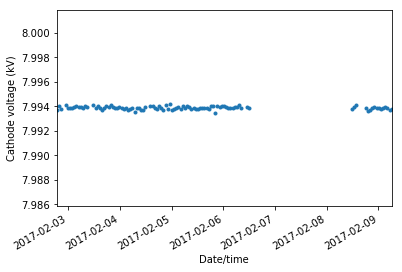

In [7]:
cathode_vs = hax.runs.get_run_info(ds.number, 'quality.hv.cathode')

plt.scatter(ds.start.values, cathode_vs, marker='.')
plt.xlabel('Date/time')
plt.ylabel('Cathode voltage (kV)')
plt.xlim(ds.start.values[0], ds.start.values[-1])
plt.gcf().autofmt_xdate()

Or the effective DAQ live-time:

In [8]:
l_fr = hax.runs.get_run_info(ds.number, 'quality.daq.extracted.livetime')
ds['corrected_livetime'] = ds['livetime'].values * l_fr
ds['corrected_livetime'].sum()

Timedelta('4 days 02:47:12.927186')

## Loading data

Let's load a fragment of the SR1 data. This will take a minute to run:

In [9]:
data = hax.minitrees.load(ds.number[:100],
                          preselection=['cs1 > 0', 'cs1 < 200'],
                          cache_file='my_secret_stash.hdf5',
                          num_workers=5)

(((cs1<252) & (log(cs2_bottom/cs1)/log(10) > 0.466119*exp(-cs1/47.9903) + 1.31033 -0.000314047*cs1 + 1.33977/cs1)) | ((cs1<20) & (log(cs2_bottom/cs1)/log(10) < 1.08159)) | ((20<=cs1) & (log(cs2_bottom/cs1)/log(10) < 1.21239 + -0.0016025*cs1 + -1.97495/cs1)) | ((cs1<500) & (r_3d_nn>47.9)) | (cs1<80) | ((cs1>=375) & (log(cs2_bottom/cs1)/log(10) > 1.02015)) | (cs1>3000) | (largest_other_s2 > 200) | (s2<200) | ((250<cs1) & (cs1<375) & (log(cs2_bottom/cs1)/log(10) > 0.822161*exp(-(cs1-207.702)/343.275) + 0.515139))) & (((0.0137*(cs1/.1429 + cs2_bottom/11.36) < 50.) | (0.0137*(cs1/.1429 + cs2_bottom/11.36) > 80.)) | ((run_number>=8340) & (run_number<=8728)) | ((run_number>17580) & (run_number<=17820))) & (((0.0137*(cs1/.1429 + cs2_bottom/11.36) < 2300.) | (0.0137*(cs1/.1429 + cs2_bottom/11.36) > 2600.))) selection: 313340 rows removed (83.68% passed)
cs1 > 0 selection: 0 rows removed (100.00% passed)
cs1 < 200 selection: 1567017 rows removed (2.48% passed)


Notice we did things slightly differently than in the previous tutorial:
  * We did not specify any minitrees to load (like 'Basics'). By default, it will then load all minitrees needed to run the current set of cuts.
  * The `preselection` option specifies cuts to use while loading the data. The syntax for these 'cut strings' is that of [pandas.query](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.query.html).
    * If you're loading many datasets, this option is essential to memory usage low. We loaded 100 datasets (out of ~6000) and used ~60 MB of memory (see `data.info()`); without preselections this would be ~2.5 GB! Hax applies preselections to each dataset before the results are concatenated, so you never need to claim that 2.5 GB. This is a basic form of out-of-core processing; for more advanced out-of-core options, see [other notebook].
  * The `cache_file` option ensure the results of the .load are cached to a file in the current directory. Try running the cell above again; it will run almost instantly thanks to this. There is absolutely no check whether the cache file is up to date or not: if you change your dataset selection or preselection, **you** must delete this file!
  * The `num_workers` option specifies how many CPUs to use for loading minitrees. Obviously you must be running on a multi-core machine for this to give a speedup.
  
Note also the printed output: three cuts were applied during loading. The last two are the preselections (notice  one of them didn't do anything), the first (with the really long cutstring) is the blinding cut. This is applied automatically to background data, and occasionally changes depending on the state of the analysis. Even if you've pegged your pax version (as above), this will ensure your analysis inputs can still change without warning. It wouldn't be exciting otherwise...

# Event selection

Rather than applying our own custom event selections, let's apply pre-made event selections from lax (called 'lichens'). All cuts blessed for mainstream low-energy background analysis are in LowEnergyBackground:

In [10]:
d = hax.cuts.apply_lichen(data, 'LowEnergyBackground')

LowEnergyBackground v1.5.1 selection: 39856 rows removed (0.08% passed)


Notice this lists the version of the cut as well as what it did. Remember you can use hax.cuts.history to see what  cuts have been applied:

In [11]:
hax.cuts.history(d)

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,(((cs1<252) & (log(cs2_bottom/cs1)/log(10) > 0...,1920246,1606906,313340,0.836823,0.836823
1,cs1 > 0,1606906,1606906,0,1.000000,0.836823
2,cs1 < 200,1606906,39889,1567017,0.024823,0.020773
3,LowEnergyBackground v1.5.1,39889,33,39856,0.000827,0.000017


and notice this includes the preselections. 

You can also use lax selections as preselections: just use the lichen name again. For example, `preselection=['FiducialCylinder1T', 'cs1 < 200']` will select all cS1<200 PE events in a 1T fiducial volume. 

LowEnergyBackground is not a single cut but summarizes many cuts; if you want to see the details of these, pass `deep=True` to `apply_lichen`:

In [12]:
d = hax.cuts.apply_lichen(data, 'LowEnergyBackground', deep=True)

FiducialZOptimized v4 selection: 34892 rows removed (12.53% passed)
S1LowEnergyRange v0 selection: 0 rows removed (100.00% passed)
S2Threshold v1 selection: 1258 rows removed (74.82% passed)
InteractionPeaksBiggest v0 selection: 3565 rows removed (4.65% passed)
CS2AreaFractionTop v0 selection: 93 rows removed (46.55% passed)
S2SingleScatterSimple v2 selection: 31 rows removed (61.73% passed)
S2Width v6 selection: 7 rows removed (86.00% passed)
DAQVeto v1 selection: 0 rows removed (100.00% passed)
S1SingleScatter v3 selection: 3 rows removed (93.02% passed)
S2PatternLikelihood v3 selection: 1 rows removed (97.50% passed)
KryptonMisIdS1 v0 selection: 1 rows removed (97.44% passed)
Flash v0 selection: 0 rows removed (100.00% passed)
PosDiff v4 selection: 0 rows removed (100.00% passed)
SingleElectronS2s v5 selection: 0 rows removed (100.00% passed)
S1PatternLikelihood v3 selection: 0 rows removed (100.00% passed)
S1MaxPMT v0 selection: 1 rows removed (97.37% passed)
S1AreaFractionTop v4 s

With these cuts applied, you're left with our best selection of low-energy data (though as mentioned this is only a fragment of the full dataset). Feel free to explore, e.g.:

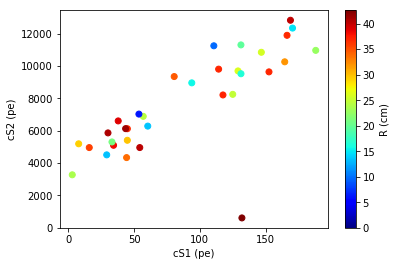

In [13]:
plt.scatter(d['cs1'], d['cs2'], 
            c=d['r'], vmin=0, cmap=plt.cm.jet)
plt.colorbar(label="R (cm)")
plt.xlabel("cS1 (pe)")
plt.ylabel("cS2 (pe)")

You now know enough about hax to do basic analyses. Have a look at some notebooks from others for more examples. The next tutorial will cover more advanced features of hax, such as creating custom minitrees, which you will likely not need immediately.